In [1]:
using NPZ
using CSV
using Plots
using FFTW
using Optim
using Statistics
using DataFrames
using Distributed
using ProgressBars
using OffsetArrays
using SparseArrays
using StaticArrays
using SharedArrays
using LinearAlgebra
using BenchmarkTools
using DelimitedFiles

# include custom code
include("./Test/runtests.jl")
include("./Source/ActivePolymer.jl")
using .ActivePolymer
using .ActivePolymer.CorrelationMatrices

Test Summary:                             | Pass  Total  Time
Validation of transforms.                 |    7      7  5.6s
  Forward transforms vs analytic results. |    3      3  2.1s
  Inverse transforms vs input values.     |    4      4  3.5s


In [2]:
profile = npzread("../Share/ABidentities_blobel2021_chr2_35Mb_60Mb.npy") .==1

ratio   = 5.974;
diff    = (ratio - 1)/(ratio+1);
Tₐ      = 1 .+ diff * 2*(profile .- 0.5);
T₀      = 1 .+ 0.0  * 2*(profile .- 0.5);

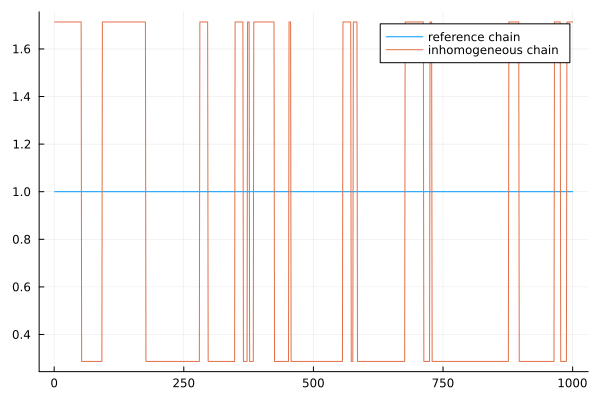

In [3]:
plot(T₀, label="reference chain")
plot!(Tₐ, label="inhomogeneous chain")

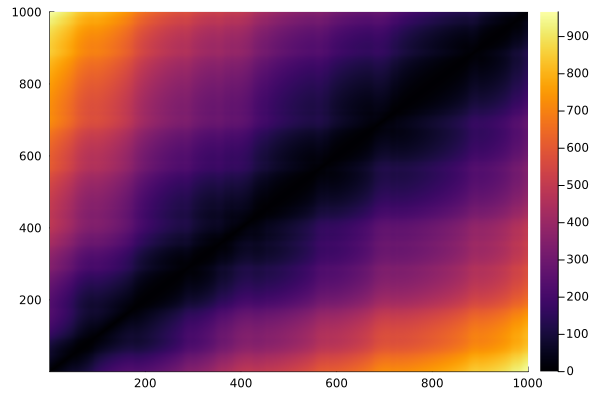

In [4]:
ΔR_numeric    = ActivePolymer.Transform.Forward.compute_conformation(
    Tₐ |> diagm, fourier_type=ActivePolymer.Methods.FastFourier.DCT
    ) |> ActivePolymer.Methods.Real.correlation_to_separation;
heatmap(ΔR_numeric)

In [5]:
Nₜ = 1000;
τs  = exp.(range(-6,18,Nₜ));

ΔR²reference_mean = fill(0.0,Nₜ)
ΔR²reference_n500 = fill(0.0,Nₜ)
for (id, τ) in enumerate(τs)
    msd = ActivePolymer.Transform.Forward.compute_mean_squared_traveled_distance(
        T₀ |> diagm, 
        ActivePolymer.Jacobian.Discrete.J₀,
        τ,
        fourier_type=ActivePolymer.Methods.FastFourier.DCT
    )
    ΔR²reference_mean[id] = msd |> mean
    ΔR²reference_n500[id] = msd[500]
end

ΔR²mean = fill(0.0,Nₜ)
ΔR²hot_mean  = fill(0.0,Nₜ)
ΔR²cold_mean = fill(0.0,Nₜ)
ΔR²hot_n350  = fill(0.0,Nₜ)
ΔR²cold_n500 = fill(0.0,Nₜ)
for (id, τ) in enumerate(τs)
    msd = ActivePolymer.Transform.Forward.compute_mean_squared_traveled_distance(
        Tₐ |> diagm, 
        ActivePolymer.Jacobian.Discrete.J₀,
        τ,
        fourier_type=ActivePolymer.Methods.FastFourier.DCT
    );
    ΔR²mean[id] = msd |> mean
    ΔR²hot_mean[id]  = msd[profile] |> mean
    ΔR²cold_mean[id] = msd[.!profile] |> mean
    ΔR²hot_n350[id]  = msd[350]
    ΔR²cold_n500[id] = msd[500]    
end

In [6]:
data = DataFrame(
    τs = τs,
    reference_mean = ΔR²reference_mean,
    reference_n500 = ΔR²reference_n500,
    mean = ΔR²mean,
    hot_mean = ΔR²hot_mean,
    cold_mean = ΔR²cold_mean,
    hot_n350 = ΔR²hot_n350,
    cold_n500 = ΔR²cold_n500
);
CSV.write("discrete_diffusion_msd.csv", data)

"discrete_diffusion_msd.csv"

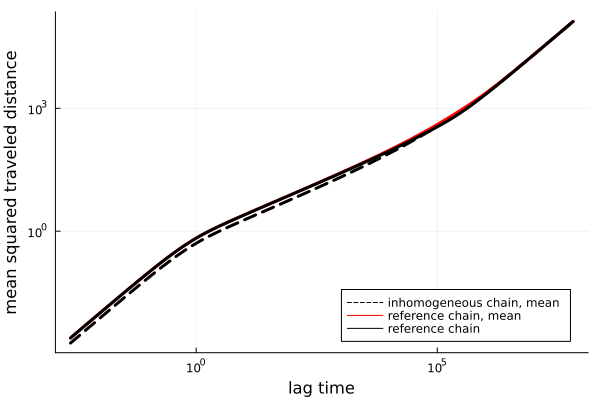

In [7]:
plot(τs, ΔR²mean, xaxis=:log, yaxis=:log, legend=:bottomright,
    xlabel = "lag time",
    ylabel = "mean squared traveled distance",
    label="inhomogeneous chain, mean",
    lc=:black,
    ls=:dash,
    lw=3
)

plot!(τs, ΔR²reference_mean, xaxis=:log, yaxis=:log, legend=:bottomright,
    xlabel = "lag time",
    ylabel = "mean squared traveled distance",
    label="reference chain, mean",
    lc=:red,
    lw=3
)
plot!(τs, ΔR²reference_n500, xaxis=:log, yaxis=:log, legend=:bottomright,
    xlabel = "lag time",
    ylabel = "mean squared traveled distance",
    label="reference chain",
    lc=:black,
    lw=3
)

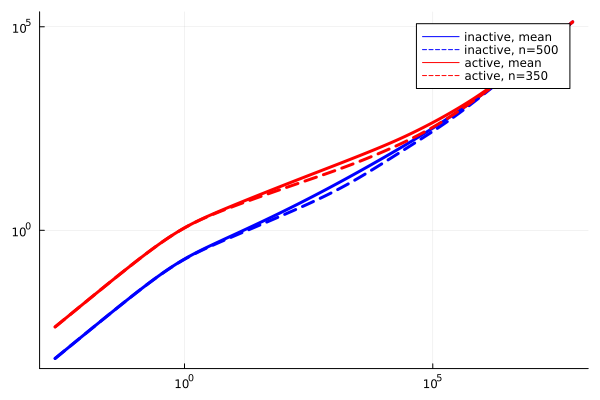

In [8]:
plot(τs, ΔR²cold_mean, xaxis=:log, yaxis=:log, label="inactive, mean",
    lc=:blue,
    lw=3
)
plot!(τs, ΔR²cold_n500, xaxis=:log, yaxis=:log, label="inactive, n=500",
    lc=:blue,
    ls=:dash,
    lw=3
)

plot!(τs, ΔR²hot_mean, xaxis=:log, yaxis=:log, label="active, mean",
    lc=:red,
    lw=3
)
plot!(τs, ΔR²hot_n350, xaxis=:log, yaxis=:log, label="active, n=350",
    lc=:red,
    ls=:dash,
    lw=3
)

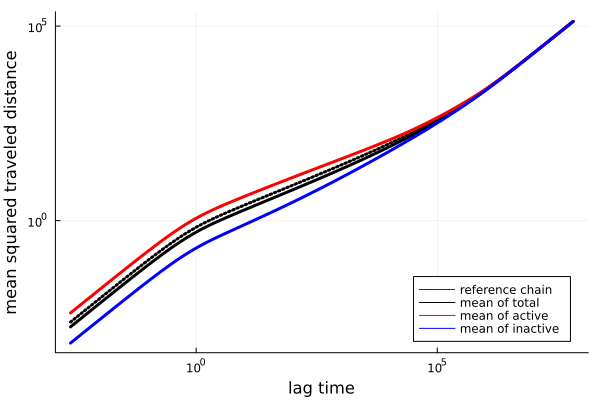

In [9]:
plot(τs, ΔR²reference_mean, xaxis=:log, yaxis=:log, legend=:bottomright,
    xlabel = "lag time",
    ylabel = "mean squared traveled distance",
    label="reference chain",
    lc=:black,
    ls=:dot,
    lw=3
)
plot!(τs, ΔR²mean, xaxis=:log, yaxis=:log, legend=:bottomright,
    label="mean of total",
    lc=:black,
    lw=3
)
#plot!(τs, τs, lc=:black, ls=:dash)
#plot!(τs, sqrt.(τs), lc=:black, ls=:dash)
plot!(τs, ΔR²hot_mean, xaxis=:log, yaxis=:log, label="mean of active",
    lc=:red,
    lw=3
)
plot!(τs, ΔR²cold_mean, xaxis=:log, yaxis=:log, label="mean of inactive",
    lc=:blue,
    lw=3
)